# 📦 Importing Packages

In [2]:
# 📦 Standard Library
import os
import re
import time
import random
from collections import defaultdict
from typing import Iterable, List
from itertools import combinations

# 📊 Data & Numerics
import numpy as np
import pandas as pd

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🤖 ML / NLP
import torch
import spacy
import emoji
from nltk.stem import SnowballStemmer
import joblib

# 🧪 Scikit-learn
from sklearn.model_selection import (
    GroupShuffleSplit, GroupKFold, # StratifiedKFold,
    GridSearchCV, cross_validate
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    make_scorer,
    accuracy_score, precision_score,
    recall_score, f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import clone

from scipy import stats

from multiprocessing import Manager

# 🧭 Utils
from tqdm.auto import tqdm

from nlp_for_ml.preprocessing import (
    identity_tokenizer,
    # SklearnGensimBowVectorizer,
    SpacyPosNerPreprocessor,
    SpacyPosNerPreprocessorWithStemming
)

# ⚙️ Global Settings

In [3]:
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")

GLOBAL_SEED = 42
DATASET_TYPE = "toxicity"
TASK = 'multiclass'  # else 'multiclass'
DATASET_PATH = os.path.join(".", "out", "datasets", f"cipv-chats-{TASK}-{DATASET_TYPE}.parquet")
NESTED_CV_RESULTS_PATH = os.path.join(".", "out", "models", DATASET_TYPE, f"entire-chat-{TASK}-classification", "nested-cv-results", timestamp)

if TASK == 'binary':
    POLARITY_BINS = [-1.01, -0.35, 1.01]
    POLARITY_LABELS = [0, 1]  # 0: Toxic, 1: Healthy
    TARGET_NAMES = ['Toxic', 'Healthy']
else:
    POLARITY_BINS = [-1.01, -0.35, 0.35, 1.01]
    POLARITY_LABELS = [0, 1, 2]
    TARGET_NAMES = ['Toxic', 'Neutral', 'Healthy']
    cost_mat = np.array([
        [0, 8, 16],
        [8, 0, 1],
        [16, 4, 0]
    ])
    # rows = true labels
    # cols = predicted labels
    # so cost_mat[i, j]
    # gives the cost of predicting j when the true label is i

OUT_DIR = os.path.join(".", "out", "models", f"{DATASET_TYPE}", f"entire-chat-{TASK}-classification", f"{timestamp}")

# 🛠️ Utility Functions

In [60]:
def set_global_seed(seed=GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(GLOBAL_SEED)

def plot_confusion_matrix(cm, classes, path=None):
    """
    Plots the confusion matrix.
    """
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
        xticklabels=classes, 
        yticklabels=classes
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()
    plt.close()

# 📂 Dataset Loading

In [39]:
df = pd.read_parquet(DATASET_PATH)
df['messages'] = df['messages'].apply(
    lambda x: "\n\n".join([msg['content'] for msg in x])
)
print(df)

               couple_ids                                           messages  \
0     2025-07-09-15-56-39  Ciao Marco, come stai?\n\nCiao Sofia. Tutto be...   
1     2025-07-09-15-56-39  Ciao Marco, a che ora torni stasera? Ho prepar...   
2     2025-07-09-15-56-39  Ciao Marco, come va? Volevo chiederti se stase...   
3     2025-07-09-15-56-39  Ciao Marco, cosa fai oggi?\n\nEsco.\n\nAh, ok....   
4     2025-07-09-15-56-39  Ciao Marco! 😊 Hai dormito bene?\n\nCiao Sofia....   
...                   ...                                                ...   
1804  2025-07-09-15-34-19  Ciao Marco. Come ti senti oggi? Io mi sono sve...   
1805  2025-07-09-15-34-19  Ciao Marco. So che abbiamo bisogno di parlare ...   
1806  2025-07-09-15-34-19  Marco, dobbiamo parlare. Non possiamo continua...   
1807  2025-07-09-15-34-19  Marco, credo che dovremmo parlare apertamente ...   
1808  2025-07-09-15-34-19  Ciao Marco. So che abbiamo deciso di separarci...   

      labels  
0          2  
1        

# 📂 Dataset Splitting

In [40]:
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=GLOBAL_SEED)
train_val_idx, test_idx = next(gss_test.split(
    X=df['messages'], 
    y=df['labels'], 
    groups=df['couple_ids']
))

test_df = df.iloc[test_idx].copy()
train_val_df = df.iloc[train_val_idx].copy()

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=GLOBAL_SEED)
train_idx, val_idx = next(gss_val.split(
    X=train_val_df['messages'], 
    y=train_val_df['labels'], 
    groups=train_val_df['couple_ids']
))

val_df = train_val_df.iloc[val_idx].copy()
train_df = train_val_df.iloc[train_idx].copy()

print(f"Train/Eval Set Size: {len(train_val_df)} ({len(train_val_df) / len(df) * 100:.2f}%)")
print(f"Couples in Train/Eval Set: {train_val_df['couple_ids'].nunique()}")

print(f"\nTest Set Size: {len(test_df)} ({len(test_df) / len(df) * 100:.2f}%)")
print(f"Couples in Test Set: {test_df['couple_ids'].nunique()}")

print(f"\nTrain Set Size: {len(train_df)} ({len(train_df) / len(df) * 100:.2f}%)")
print(f"Couples in Train Set: {train_df['couple_ids'].nunique()}")

print(f"\nValidation Set Size: {len(val_df)} ({len(val_df) / len(df) * 100:.2f}%)")
print(f"Couples in Validation Set: {val_df['couple_ids'].nunique()}")

Train/Eval Set Size: 1435 (79.33%)
Couples in Train/Eval Set: 47

Test Set Size: 374 (20.67%)
Couples in Test Set: 12

Train Set Size: 1089 (60.20%)
Couples in Train Set: 37

Validation Set Size: 346 (19.13%)
Couples in Validation Set: 10


# ✨ Pre-Process

In [41]:
nlp = spacy.load("it_core_news_sm")
# nlp.disable_pipes(*[name for name in nlp.pipe_names if name != "lemmatizer"])

# preprocessor = SpacyPosNerPreprocessorWithStemming(
#     nlp, SnowballStemmer("italian"),
#     ner_to_replace=['PERSON', 'ORG', 'LOC'],
#     pos_whitelist=['VERB', 'ADJ', 'ADV', 'NOUN', 'INTJ', 'PRON', 'AUX']
# )

preprocessor = SpacyPosNerPreprocessor(
    nlp, ner_to_replace=['PERSON', 'ORG', 'LOC'],
    pos_whitelist=['VERB', 'ADJ', 'ADV', 'NOUN', 'INTJ', 'PRON', 'AUX']
)

X_train = train_val_df['messages'].map(lambda x: preprocessor(x))
X_test = test_df['messages'].map(lambda x: preprocessor(x))

# 📄​ Methodology

In [42]:
class CostSensitiveClassifier(BaseEstimator, ClassifierMixin):
    """
    A scikit-learn compatible wrapper that makes any classifier
    with predict_proba cost-sensitive given a cost matrix.
    """
    def __init__(self, base_estimator, cost_matrix):
        self.base_estimator = base_estimator
        self.cost_matrix = cost_matrix  # Store as-is, don't convert to numpy here
        self.__name__ = "CostSensitive" + self.base_estimator.__class__.__name__

    def fit(self, X, y):
        """
        Fit the base estimator normally.
        """
        self.clf_ = clone(self.base_estimator)
        self.clf_.fit(X, y)
        # Convert to numpy array only when needed
        self._cost_matrix_array = np.array(self.cost_matrix)
        return self
    
    def predict(self, X):
        """
        Predict labels by minimizing expected cost.
        """
        probas = self.clf_.predict_proba(X)  # shape (n_samples, n_classes)
        expected_cost = probas @ self._cost_matrix_array
        return np.argmin(expected_cost, axis=1)
    
    def predict_proba(self, X):
        """
        Just forward the probability estimates of the base classifier.
        """
        return self.clf_.predict_proba(X)
    
    def score(self, X, y):
        """
        By default, use negative expected cost as a score
        (higher is better).
        """
        probas = self.clf_.predict_proba(X)
        expected_costs = (probas @ self._cost_matrix_array)[np.arange(len(y)), y]
        return -np.mean(expected_costs)

In [43]:
def compute_worst_case_cost(y_true, cost_matrix):
    """
    Computes the total worst-case cost for a given dataset.

    The worst-case cost is calculated by assuming that for every sample,
    the model makes the most expensive possible prediction error.

    Args:
        y_true (array-like): A 1D array of true class labels for the dataset.
            It's assumed that labels are integers from 0 to n_classes-1,
            corresponding to the indices of the cost matrix.
        cost_matrix (array-like): A 2D array (or list of lists) where
            cost_matrix[i][j] is the cost of predicting class j when the
            true class is i.

    Returns:
        float: The total worst-case cost for the entire dataset.
    """
    # 1. Convert inputs to NumPy arrays for efficient computation
    y_true = np.asarray(y_true)
    cost_matrix = np.asarray(cost_matrix)

    # 2. Validate inputs
    n_classes = cost_matrix.shape[0]
    if cost_matrix.shape[1] != n_classes:
        raise ValueError("Cost matrix must be square.")
    if np.max(y_true) >= n_classes:
        raise ValueError(f"y_true contains labels greater than the number "
                         f"of classes defined by the cost matrix ({n_classes-1}).")

    # 3. Find the maximum possible cost for each true class (row)
    # This finds the most expensive error for each possible true class.
    # axis=1 computes the max along each row.
    max_cost_per_class = np.max(cost_matrix, axis=1)

    # 4. Count the number of samples for each true class
    # np.bincount is very fast for this. It counts occurrences of each integer.
    # minlength ensures the output array has a size of n_classes, even if
    # some classes are not present in y_true.
    class_counts = np.bincount(y_true, minlength=n_classes)

    # 5. Calculate the total worst-case cost
    # This is the element-wise product of (count of class i) * (max cost for class i),
    # summed over all classes.
    total_worst_cost = np.sum(class_counts * max_cost_per_class)

    return total_worst_cost

def calculate_total_cost(y_true, y_pred):
    """
    Calculates the total cost of predictions using a cost matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels  
        cost_mat: Cost matrix where cost_mat[i,j] is the cost of 
                 predicting class j when true class is i
    
    Returns:
        Total cost (scalar)
    """
    # Generate labels that match cost matrix dimensions
    # Assumes labels are 0, 1, 2, ..., num_classes-1
    num_classes = cost_mat.shape[0]
    labels = np.arange(num_classes)
    
    # Get confusion matrix with all possible labels
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate total cost
    return np.sum(conf_mat * cost_mat) / compute_worst_case_cost(y_true, cost_mat)

In [44]:
cost_scorer = make_scorer(calculate_total_cost, greater_is_better=False)

def do_experiment(X_train, y_train, X_test, y_test, groups, pipeline, p_grid, save_path):
    grid_search = GridSearchCV(
        pipeline,  p_grid,
        cv=GroupKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED),
        scoring=cost_scorer, # 'f1_weighted',
        n_jobs=1, verbose=2,
        # return_train_score=True,
    )

    grid_search.fit(X_train, y_train, groups=groups)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results.to_csv(os.path.join(save_path, "cv_results.csv"), index=False)

    best_params = grid_search.best_params_
    best_pipeline = pipeline.set_params(**best_params)

    best_pipeline.fit(X_train, y_train)

    y_pred = best_pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=TARGET_NAMES) # , output_dict=True

    with open(os.path.join(save_path, "classification_report.txt"), "w") as f:
        f.write(report)
        if TASK == 'multiclass':
            cost = calculate_total_cost(y_test, y_pred)
            f.write(f"\nTotal Cost: {cost}\n")
    print(report)
    # report_df = pd.DataFrame(report).transpose()
    # report_df.to_csv(os.path.join(save_path, "classification_report.csv"), index=False)

    # plot and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(
        cm, 
        classes=TARGET_NAMES, 
        path=os.path.join(save_path, "confusion_matrix.png")
    )

    # Save the best model
    joblib.dump(best_pipeline, os.path.join(save_path, "best_model_pipeline.pkl"))

In [45]:
# Create a manager to handle shared objects
manager = Manager()
shared_matrices = manager.list()

class ConfusionMatrixScorer:
    def __init__(self, labels):
        self.labels = labels
        # self.shared_list = shared_matrices
        self.__name__ = "confusion_matrix"

    def __call__(self, y_true, y_pred):
        try:
            cm = confusion_matrix(y_true, y_pred, labels=self.labels)
            # Append to the shared list
            shared_matrices.append(cm.tolist())
            return 0  # Return a dummy score
        except Exception as e:
            print(f"Error in confusion matrix scorer: {e}")
            return 0
    
    def reset(self):
        pass

def get_scoring_metrics():   
    # Dynamically create scorers for each class and for macro/weighted averages
    scoring_metrics = {'accuracy': make_scorer(accuracy_score)}

    scoring_metrics['confusion_matrix'] = make_scorer(ConfusionMatrixScorer(labels=POLARITY_LABELS))

    if TASK == 'multiclass':
        scoring_metrics['cost'] = cost_scorer

    for average in ['macro', 'weighted']:
        scoring_metrics[f'precision_{average}'] = make_scorer(precision_score, average=average, zero_division=0)
        scoring_metrics[f'recall_{average}'] = make_scorer(recall_score, average=average, zero_division=0)
        scoring_metrics[f'f1_{average}'] = make_scorer(f1_score, average=average, zero_division=0)

    for label, name in zip(POLARITY_LABELS, TARGET_NAMES):
        # Scikit-learn uses pos_label for binary classification scorers
        if TASK == 'binary':
            scoring_metrics[f'precision_{name.lower()}'] = make_scorer(precision_score, pos_label=label, zero_division=0)
            scoring_metrics[f'recall_{name.lower()}'] = make_scorer(recall_score, pos_label=label, zero_division=0)
            scoring_metrics[f'f1_{name.lower()}'] = make_scorer(f1_score, pos_label=label, zero_division=0)
        # and the 'labels' parameter for multiclass
        else:
            scoring_metrics[f'precision_{name.lower()}'] = make_scorer(precision_score, labels=[label], average='micro', zero_division=0)
            scoring_metrics[f'recall_{name.lower()}'] = make_scorer(recall_score, labels=[label], average='micro', zero_division=0)
            scoring_metrics[f'f1_{name.lower()}'] = make_scorer(f1_score, labels=[label], average='micro', zero_division=0)

    return scoring_metrics

def confidence_interval(scores, confidence_level=0.95):
    """
    Computes the confidence interval for a given performance metric.

    This function is useful for understanding the reliability of a single model's 
    mean performance score from cross-validation.

    Args:
        scores (list or np.ndarray): A list of scores from cross-validation folds.
        confidence_level (float): The desired confidence level (e.g., 0.95 for 95%).

    Returns:
        tuple: A tuple containing the mean score, and the lower and upper bounds 
               of the confidence interval (mean, lower_bound, upper_bound).
    """
    n = len(scores)
    if n <= 1:
        # Cannot compute CI for 1 or 0 scores, return mean and NaN for bounds
        return (np.mean(scores), np.nan, np.nan)
        
    mean_score = np.mean(scores)
    # Standard Error of the Mean (SEM) = Sn / sqrt(n)
    # where Sn is the standard deviation of the scores
    std_err = stats.sem(scores)
    
    # Degrees of freedom
    dof = n - 1
    
    # Get the critical value from the t-distribution
    t_critical = stats.t.ppf((1 + confidence_level) / 2., dof)
    
    margin_of_error = t_critical * std_err
    
    lower_bound = mean_score - margin_of_error
    upper_bound = mean_score + margin_of_error
    
    return (mean_score, lower_bound, upper_bound)

def print_and_save_classification_report_conf_intervals(cv_results, save_path, confidence=0.95):
    with open(os.path.join(save_path, "classification_report_with_cv.txt"), "w", encoding="utf-8") as f:
        f.write(f"=== Cross-Validation Results (Mean ± Std [{confidence * 100:.0f}% CI]) ===\n\n")
        print(f"=== Cross-Validation Results (Mean ± Std [{confidence * 100:.0f}% CI]) ===\n")

        # Create the classification report format
        report_lines = []
        
        # Header
        header = f"{'':>14} {'precision':>27} {'recall':>27} {'f1-score':>27}"
        report_lines.append(header)
        report_lines.append("")
        
        # Per-class metrics
        for i, name in enumerate(TARGET_NAMES):
            name_lower = name.lower()
            
            # Calculate confidence intervals for each metric
            precision_scores = cv_results[f'test_precision_{name_lower}']
            precision_mean, precision_lower, precision_upper = confidence_interval(precision_scores, confidence)
            precision_std = np.std(precision_scores)

            recall_scores = cv_results[f'test_recall_{name_lower}']
            recall_mean, recall_lower, recall_upper = confidence_interval(recall_scores, confidence)
            recall_std = np.std(recall_scores)

            f1_scores = cv_results[f'test_f1_{name_lower}']
            f1_mean, f1_lower, f1_upper = confidence_interval(f1_scores, confidence)
            f1_std = np.std(f1_scores)

            # Format with confidence intervals
            precision_ci = f"{precision_mean:.2f} ± {precision_std:.2f} [{precision_lower:.2f}, {precision_upper:.2f}]"
            recall_ci = f"{recall_mean:.2f} ± {recall_std:.2f} [{recall_lower:.2f}, {recall_upper:.2f}]"
            f1_ci = f"{f1_mean:.2f} ± {f1_std:.2f} [{f1_lower:.2f}, {f1_upper:.2f}]"

            line = f"{name:>14} {precision_ci:>27} {recall_ci:>27} {f1_ci:>27}"
            report_lines.append(line)
        
        report_lines.append("")

        # Accuracy
        accuracy_scores = cv_results['test_accuracy']
        accuracy_mean, accuracy_lower, accuracy_upper = confidence_interval(accuracy_scores, confidence)
        accuracy_std = np.std(accuracy_scores)
        accuracy_ci = f"{accuracy_mean:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]"
        line = f"{'accuracy':>14} {'':>27} {'':>27} {accuracy_ci:>27}"
        report_lines.append(line)
        
        # Macro and weighted averages
        for avg_type in ['macro', 'weighted']:
            precision_scores = cv_results[f'test_precision_{avg_type}']
            precision_mean, precision_lower, precision_upper = confidence_interval(precision_scores, confidence)
            precision_std = np.std(precision_scores)

            recall_scores = cv_results[f'test_recall_{avg_type}']
            recall_mean, recall_lower, recall_upper = confidence_interval(recall_scores, confidence)
            recall_std = np.std(recall_scores)

            f1_scores = cv_results[f'test_f1_{avg_type}']
            f1_mean, f1_lower, f1_upper = confidence_interval(f1_scores, confidence)
            f1_std = np.std(f1_scores)

            # Format with confidence intervals
            precision_ci = f"{precision_mean:.2f} ± {precision_std:.2f} [{precision_lower:.2f}, {precision_upper:.2f}]"
            recall_ci = f"{recall_mean:.2f} ± {recall_std:.2f} [{recall_lower:.2f}, {recall_upper:.2f}]"
            f1_ci = f"{f1_mean:.2f} ± {f1_std:.2f} [{f1_lower:.2f}, {f1_upper:.2f}]"

            line = f"{avg_type + ' avg':>14} {precision_ci:>27} {recall_ci:>27} {f1_ci:>27}"
            report_lines.append(line)
        
        # Cost (if multiclass)
        if TASK == 'multiclass':
            # since cost is negative in scoring, change the sign
            cost_scores = - cv_results['test_cost']
            cost_mean, cost_lower, cost_upper = confidence_interval(cost_scores, confidence)
            cost_std = np.std(cost_scores)
            cost_ci = f"{cost_mean:.2f} ± {cost_std:.2f} [{cost_lower:.2f}, {cost_upper:.2f}]"
            report_lines.append("")
            report_lines.append(f"Total Cost: {cost_ci}")
        
        # Write to file and print
        report_text = "\n".join(report_lines)
        f.write(report_text)
        print(report_text)

def plot_confusion_matrices(cms, classes, path=None):
    """
    Plots a single confusion matrix showing mean ± standard deviation for each cell.
    
    Args:
        cv_results: Cross-validation results containing confusion_matrix scores
        classes: List of class names
        path: Path to save the plot
    """
    n_classes = len(classes)

    # Calculate mean and std for each cell
    cm_mean = np.mean(cms, axis=0)
    cm_std = np.std(cms, axis=0)
    
    # Create the plot
    plt.figure(figsize=(7, 5))
    
    # Create annotations with mean ± std format
    annotations = np.empty_like(cm_mean, dtype=object)
    for i in range(n_classes):
        for j in range(n_classes):
            annotations[i, j] = f'{cm_mean[i, j]:.1f} ± {cm_std[i, j]:.2f}'
    
    sns.heatmap(
        cm_mean, 
        annot=annotations, 
        fmt='', 
        cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
        xticklabels=classes, 
        yticklabels=classes,
        cbar_kws={'label': 'Mean Count'}
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix (Mean ± Std)')
    plt.tight_layout()
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def do_nested_cv(X, y, groups, pipeline, p_grid, save_path, nested_cv_results_path):
    is_in_cost_sensitive_mode = pipeline.steps[-1][1].__class__.__name__ == "CostSensitiveClassifier"

    inner_cv = GroupKFold(n_splits=3, shuffle=True, random_state=GLOBAL_SEED)
    grid_search = GridSearchCV(
        pipeline, param_grid=p_grid, cv=inner_cv,
        scoring=cost_scorer if is_in_cost_sensitive_mode else 'f1_weighted',
        n_jobs=-1,
        # verbose=2
    )
    
    outer_cv = GroupKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
    cv_results = cross_validate( # also multiple metrics
        grid_search, X,
        y, cv=outer_cv,
        scoring=get_scoring_metrics(),
        groups=groups,
        params={'groups': groups},
        n_jobs=-1, verbose=2
    )

    # Save CV results
    cv_results_df = pd.DataFrame(cv_results)
    # cv_results_df.to_csv(os.path.join(save_path, "nested_cv_results.csv"), index=False)
    cv_results_df.to_csv(nested_cv_results_path, index=False)

    # print_and_save_classification_report(cv_results, save_path)
    print_and_save_classification_report_conf_intervals(cv_results, save_path)

    # Convert the shared matrices back to numpy arrays
    confusion_matrices = []
    for cm_list in shared_matrices:
        try:
            cm = np.array(cm_list)
            confusion_matrices.append(cm)
        except Exception as e:
            print(f"Warning: Could not convert confusion matrix: {e}")

    # Plot confusion matrices with mean and std
    if confusion_matrices:
        plot_confusion_matrices(
            confusion_matrices, 
            classes=TARGET_NAMES, 
            path=os.path.join(save_path, "confusion_matrix_cv.png")
        )
    else:
        print("Warning: No confusion matrices provided for plotting")

    # Fit the GridSearchCV on the ENTIRE dataset to find the best parameters
    grid_search.fit(X, y, groups=groups)
    best_pipeline = grid_search.best_estimator_

    # Save the best model
    joblib.dump(best_pipeline, os.path.join(save_path, "best_model_pipeline.pkl"))


In [46]:
OUT_DIR += f"-{preprocessor.__class__.__name__}"
# NESTED_CV_RESULTS_PATH += f"-{preprocessor.__class__.__name__}"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(NESTED_CV_RESULTS_PATH, exist_ok=True)

# 🧪 Naive Bayes

In [47]:
pp_param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [3, 8, 20],
    'vectorizer__max_df': [0.9, 0.95, 0.99],
}

21 min:
1. outer cv: 10
2. cross validate jobs -1
3. inner cv: 5
4. grid search jobs -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.3min finished


=== Cross-Validation Results (Mean ± Std [95% CI]) ===

                                 precision                      recall                    f1-score

         Toxic    0.86 ± 0.05 [0.78, 0.93]    0.80 ± 0.05 [0.73, 0.86]    0.82 ± 0.04 [0.76, 0.89]
       Neutral    0.62 ± 0.04 [0.56, 0.68]    0.68 ± 0.06 [0.60, 0.76]    0.65 ± 0.05 [0.58, 0.71]
       Healthy    0.75 ± 0.04 [0.70, 0.80]    0.75 ± 0.06 [0.66, 0.84]    0.75 ± 0.02 [0.72, 0.77]

      accuracy                                                            0.75 ± 0.04 [0.70, 0.80]
     macro avg    0.74 ± 0.03 [0.70, 0.78]    0.74 ± 0.03 [0.70, 0.78]    0.74 ± 0.03 [0.70, 0.78]
  weighted avg    0.76 ± 0.04 [0.70, 0.81]    0.75 ± 0.04 [0.70, 0.80]    0.75 ± 0.04 [0.70, 0.80]

Total Cost: 0.12 ± 0.02 [0.09, 0.15]


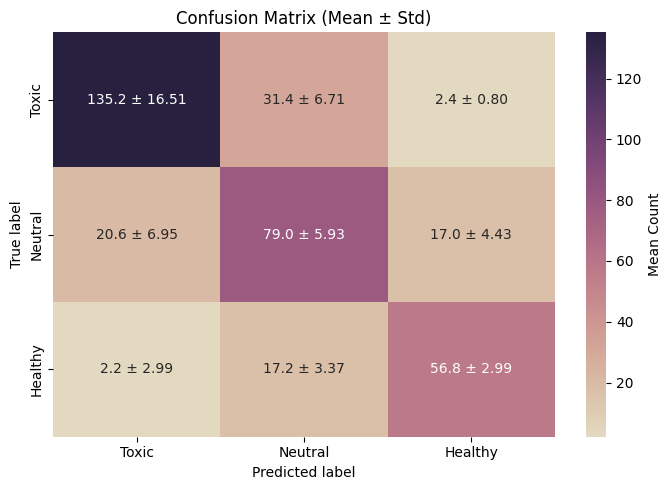

In [48]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(
        tokenizer=identity_tokenizer, lowercase=False,
        token_pattern=None, preprocessor=None
    )),
    # ("vectorizer", SklearnGensimBowVectorizer()),
    ("classifier", MultinomialNB())
])

param_grid = {**pp_param_grid, **{
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}}

save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__class__.__name__)
os.makedirs(save_path, exist_ok=True)

# do_experiment(
#     X_train, train_val_df['labels'], 
#     X_test, test_df['labels'], 
#     train_val_df['couple_ids'], 
#     pipeline, param_grid, 
#     save_path
# )
do_nested_cv(
    # X_train, train_val_df['labels'],
    # train_val_df['couple_ids'],
    df['messages'], df['labels'], 
    df['couple_ids'],
    pipeline, param_grid,
    save_path,
    os.path.join(
        NESTED_CV_RESULTS_PATH,
        preprocessor.__class__.__name__ + 'NB.csv'
    )
)

21 min:
1. outer cv: 10
2. cross validate jobs -1
3. inner cv: 5
4. grid search jobs -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.8min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.1min finished


=== Cross-Validation Results (Mean ± Std [95% CI]) ===

                                 precision                      recall                    f1-score

         Toxic    0.85 ± 0.05 [0.79, 0.92]    0.79 ± 0.04 [0.73, 0.85]    0.82 ± 0.04 [0.77, 0.87]
       Neutral    0.61 ± 0.03 [0.57, 0.66]    0.67 ± 0.05 [0.60, 0.73]    0.64 ± 0.04 [0.59, 0.69]
       Healthy    0.73 ± 0.04 [0.67, 0.79]    0.76 ± 0.06 [0.67, 0.85]    0.74 ± 0.02 [0.71, 0.77]

      accuracy                                                            0.74 ± 0.03 [0.70, 0.78]
     macro avg    0.73 ± 0.02 [0.70, 0.77]    0.74 ± 0.02 [0.70, 0.77]    0.73 ± 0.02 [0.70, 0.76]
  weighted avg    0.75 ± 0.03 [0.71, 0.80]    0.74 ± 0.03 [0.70, 0.78]    0.75 ± 0.03 [0.70, 0.79]

Total Cost: 0.12 ± 0.02 [0.10, 0.15]


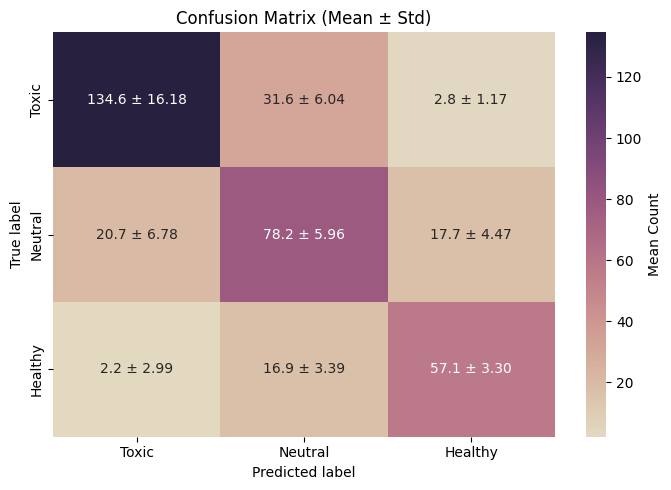

In [49]:
if TASK == 'multiclass':
    pipeline = Pipeline([
        ("vectorizer", CountVectorizer(
            tokenizer=identity_tokenizer, lowercase=False,
            token_pattern=None, preprocessor=None
        )),
        # ("vectorizer", SklearnGensimBowVectorizer()),
        ("classifier", CostSensitiveClassifier(MultinomialNB(), cost_mat))
    ])

    param_grid = {**pp_param_grid, **{
        'classifier__base_estimator__alpha': [0.1, 0.5, 1.0, 2.0]
    }}

    save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__name__)
    os.makedirs(save_path, exist_ok=True)

    # do_experiment(
    #     X_train, train_val_df['labels'], 
    #     X_test, test_df['labels'], 
    #     train_val_df['couple_ids'], 
    #     pipeline, param_grid, 
    #     save_path
    # )
    do_nested_cv(
        # X_train, train_val_df['labels'],
        # train_val_df['couple_ids'],
        df['messages'], df['labels'], 
        df['couple_ids'],
        pipeline, param_grid,
        save_path,
        os.path.join(
            NESTED_CV_RESULTS_PATH, 
            preprocessor.__class__.__name__ + 'CS_NB.csv'
        )
    )

# 🧪 Logistic Regression

36 min:
1. outer cv: 10
2. cross validate jobs -1
3. inner cv: 5
4. grid search jobs -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 15.3min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.6min finished


=== Cross-Validation Results (Mean ± Std [95% CI]) ===

                                 precision                      recall                    f1-score

         Toxic    0.83 ± 0.03 [0.78, 0.87]    0.88 ± 0.02 [0.85, 0.91]    0.85 ± 0.02 [0.82, 0.89]
       Neutral    0.66 ± 0.05 [0.60, 0.73]    0.61 ± 0.03 [0.57, 0.65]    0.63 ± 0.03 [0.60, 0.67]
       Healthy    0.77 ± 0.03 [0.73, 0.82]    0.75 ± 0.06 [0.66, 0.83]    0.76 ± 0.03 [0.71, 0.80]

      accuracy                                                            0.77 ± 0.02 [0.74, 0.79]
     macro avg    0.75 ± 0.02 [0.73, 0.77]    0.75 ± 0.02 [0.72, 0.78]    0.75 ± 0.02 [0.72, 0.77]
  weighted avg    0.76 ± 0.02 [0.73, 0.79]    0.77 ± 0.02 [0.74, 0.79]    0.76 ± 0.02 [0.73, 0.79]

Total Cost: 0.11 ± 0.01 [0.09, 0.12]


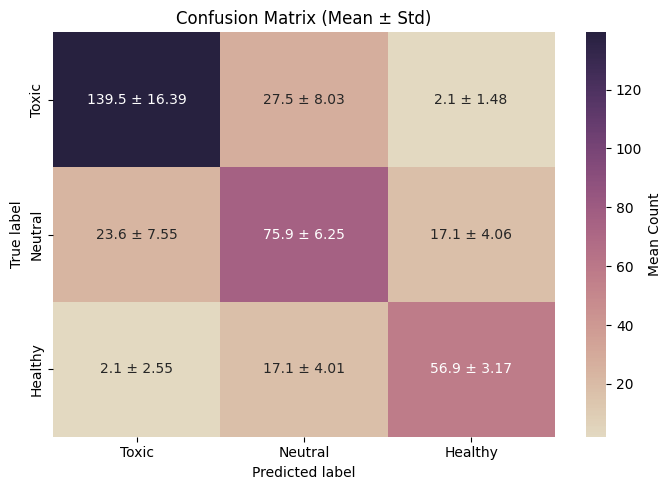

In [50]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(
        tokenizer=identity_tokenizer, lowercase=False,
        token_pattern=None, preprocessor=None
    )),
    ("classifier", LogisticRegression(
        random_state=GLOBAL_SEED, penalty='l2', 
        solver='lbfgs'
    ))
])

param_grid = {**pp_param_grid, **{
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__max_iter': [1000, 2000]
}}

save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__class__.__name__)
os.makedirs(save_path, exist_ok=True)

# do_experiment(
#     X_train, train_val_df['labels'], 
#     X_test, test_df['labels'], 
#     train_val_df['couple_ids'], 
#     pipeline, param_grid, 
#     save_path
# )
do_nested_cv(
    df['messages'], df['labels'], 
    df['couple_ids'],
    pipeline, param_grid, 
    save_path,
    os.path.join(NESTED_CV_RESULTS_PATH, preprocessor.__class__.__name__ + 'LR.csv')
)

68 min:
1. outer cv: 10
2. cross validate jobs -1
3. inner cv: 5
4. grid search jobs -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 21.9min remaining: 14.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.3min finished


=== Cross-Validation Results (Mean ± Std [95% CI]) ===

                                 precision                      recall                    f1-score

         Toxic    0.82 ± 0.05 [0.75, 0.90]    0.83 ± 0.05 [0.76, 0.89]    0.82 ± 0.04 [0.77, 0.88]
       Neutral    0.61 ± 0.02 [0.57, 0.64]    0.56 ± 0.06 [0.47, 0.65]    0.58 ± 0.04 [0.53, 0.63]
       Healthy    0.70 ± 0.03 [0.66, 0.74]    0.78 ± 0.04 [0.73, 0.84]    0.74 ± 0.03 [0.70, 0.77]

      accuracy                                                            0.73 ± 0.03 [0.69, 0.77]
     macro avg    0.71 ± 0.02 [0.68, 0.74]    0.72 ± 0.02 [0.70, 0.74]    0.71 ± 0.02 [0.68, 0.74]
  weighted avg    0.73 ± 0.03 [0.68, 0.77]    0.73 ± 0.03 [0.69, 0.77]    0.73 ± 0.03 [0.68, 0.77]

Total Cost: 0.12 ± 0.02 [0.09, 0.15]


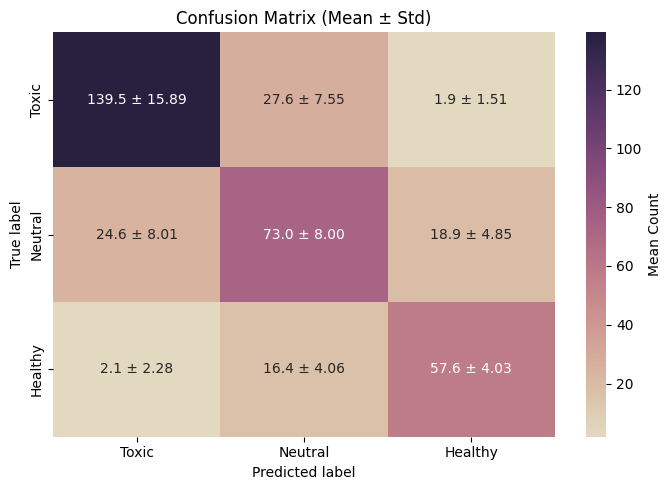

In [51]:
if TASK == 'multiclass':
    pipeline = Pipeline([
        ("vectorizer", CountVectorizer(
            tokenizer=identity_tokenizer, lowercase=False,
            token_pattern=None, preprocessor=None
        )),
        # ("vectorizer", SklearnGensimBowVectorizer()),
        ("classifier", CostSensitiveClassifier(
            LogisticRegression(
                random_state=GLOBAL_SEED, penalty='l2', 
                solver='lbfgs'
            ),
            cost_mat
        ))
    ])

    param_grid = {**pp_param_grid, **{
        'classifier__base_estimator__C': [0.1, 1.0, 10.0],
        'classifier__base_estimator__max_iter': [1000, 2000]
    }}

    save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__name__)
    os.makedirs(save_path, exist_ok=True)

    # do_experiment(
    #     X_train, train_val_df['labels'], 
    #     X_test, test_df['labels'], 
    #     train_val_df['couple_ids'], 
    #     pipeline, param_grid, 
    #     save_path
    # )
    do_nested_cv(
        df['messages'], df['labels'], 
        df['couple_ids'],
        pipeline, param_grid,
        save_path,
        os.path.join(NESTED_CV_RESULTS_PATH, preprocessor.__class__.__name__ + 'CS_LR.csv')
    )

# 🧪 SVC

19 min:
1. outer cv: 10
2. cross validate jobs -1
3. inner cv: 5
4. grid search jobs -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.1min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


=== Cross-Validation Results (Mean ± Std [95% CI]) ===

                                 precision                      recall                    f1-score

         Toxic    0.85 ± 0.03 [0.80, 0.89]    0.84 ± 0.03 [0.80, 0.88]    0.84 ± 0.03 [0.80, 0.89]
       Neutral    0.65 ± 0.04 [0.60, 0.70]    0.66 ± 0.05 [0.58, 0.73]    0.65 ± 0.03 [0.61, 0.69]
       Healthy    0.77 ± 0.06 [0.70, 0.85]    0.77 ± 0.08 [0.65, 0.89]    0.77 ± 0.03 [0.72, 0.81]

      accuracy                                                            0.77 ± 0.02 [0.73, 0.80]
     macro avg    0.76 ± 0.02 [0.72, 0.79]    0.76 ± 0.02 [0.73, 0.78]    0.75 ± 0.02 [0.73, 0.78]
  weighted avg    0.77 ± 0.03 [0.73, 0.81]    0.77 ± 0.02 [0.73, 0.80]    0.77 ± 0.03 [0.73, 0.80]

Total Cost: 0.11 ± 0.01 [0.09, 0.13]


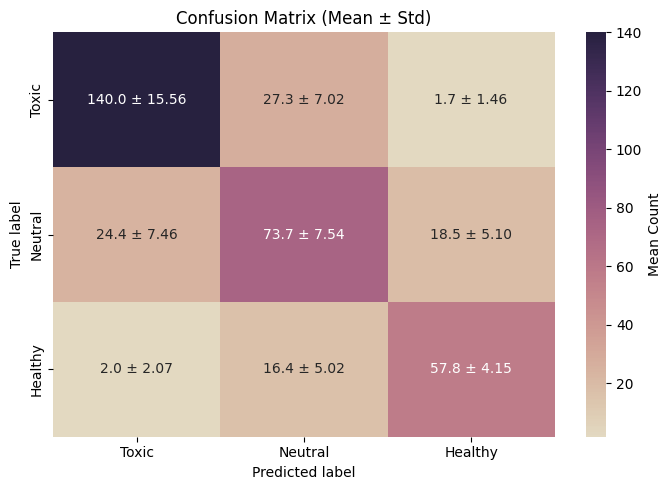

In [52]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(
        tokenizer=identity_tokenizer, lowercase=False,
        token_pattern=None, preprocessor=None
    )),
    ("classifier", SVC(
        random_state=GLOBAL_SEED,
        gamma='scale', kernel='rbf',
        class_weight='balanced', C=1.0,
        # probability=True
    ))
])

param_grid = {**pp_param_grid, **{
    # 'classifier__C': [0.1, 1.0, 10.0],
    # 'classifier__kernel': ['linear', 'rbf'],
    # 'classifier__gamma': ['scale', 'auto']
}}

save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__class__.__name__)
os.makedirs(save_path, exist_ok=True)

# do_experiment(
#     X_train, train_val_df['labels'], 
#     X_test, test_df['labels'], 
#     train_val_df['couple_ids'], 
#     pipeline, param_grid, save_path
# )
do_nested_cv(
    df['messages'], df['labels'], 
    df['couple_ids'],
    pipeline, param_grid, 
    save_path,
    os.path.join(NESTED_CV_RESULTS_PATH, preprocessor.__class__.__name__ + 'SVC.csv')
)